# CLASSIFICATION

### CLASSIFICATION PLAN:
We collected the labelled data from 2 different origins:
1. KMeans Clustering result (which will be called original data): 3 distinct classes, one of which is highly imbalanced
2. Fuzzy Kmeans Clustering result (which will be called fuzzy data): 3 distinct classes, not on same magnitude but also not particularly imbalanced

Different approach will be evaluated:
* Apply classification on original train set i.e. high imbalance in data
* Apply classification on oversampled original train set (robust oversampling method -> SMOTE)
* Apply classification on oversampled original train set and test set (robust oversampling method -> SMOTE)
* Apply classification on fuzzy train set i.e. more balanced data

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
import pydotplus 
from IPython.display import Image 
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint as sp_randint
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

***

In [2]:
# UTILITY FUNCTIONS

#function to discretize the variables, categorical, to numerical
#input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

#metrics computed on the test set
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=classes))

***

# WORKING ON ORIGINAL DATA

***

In [3]:
# Starting dataset
df = pd.read_csv('datasets/clustered_dataframe.csv', sep='\t', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4333 entries, 17850 to 12713
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TProd           4333 non-null   int64  
 1   DProd           4333 non-null   int64  
 2   MeanProdOrder   4333 non-null   float64
 3   TSale           4333 non-null   float64
 4   MinPSale        4333 non-null   float64
 5   MaxPSale        4333 non-null   float64
 6   MeanSaleOrder   4333 non-null   float64
 7   TRProd          4333 non-null   int64  
 8   MeanPSale       4333 non-null   float64
 9   TOrder          4333 non-null   int64  
 10  SETSaleQta      4333 non-null   float64
 11  SESaleQtaOrder  4333 non-null   float64
 12  MaxOrderMonth   4333 non-null   object 
 13  Label           4333 non-null   object 
dtypes: float64(8), int64(4), object(2)
memory usage: 507.8+ KB


In [4]:
# we only have 2 categorical attributes, discretize them and get rid of them
df = discretize_data(df,['MaxOrderMonth','Label'])
df.drop(columns=['MaxOrderMonth','Label'], inplace=True, errors='ignore')
df_class = df.copy()
df_class.tail()

,TProd,DProd,MeanProdOrder,TSale,MinPSale,MaxPSale,MeanSaleOrder,TRProd,MeanPSale,TOrder,SETSaleQta,SESaleQtaOrder,MaxOrderMonth_num,Label_num
CustomerID,,,,,,,,,,,,,,
13436,76,12,76.0,196.89,10.20,25.50,196.89,0,5.830,1,3.418,0.0,1,1
15520,314,18,314.0,343.50,9.48,34.68,343.50,0,1.724,1,2.997,0.0,1,1
13298,96,2,96.0,360.00,90.00,270.00,360.00,0,3.750,1,1.000,0.0,1,1
14569,79,10,79.0,227.39,1.65,122.40,227.39,0,3.920,1,3.418,0.0,1,1
12713,505,37,505.0,794.55,5.04,71.70,794.55,0,2.085,1,4.101,0.0,11,2


In [5]:
#to classify, we first need to split the dataset into train and test dataset.
#we can do so using train_test_split, in this case we select a stratified split
label = df_class.pop('Label_num')
train_set, test_set, train_label, test_label = train_test_split(df_class, label, test_size=0.30)

***

## CLASSIFICATION on ORIGINAL TRAIN SET

### Decision Tree (only to illustrate possible method results)

In [6]:
#define a decision tree and fit it
dt = tree.DecisionTreeClassifier(criterion='gini', splitter='best', 
                                  max_depth=10, 
                                  min_samples_split=3, min_samples_leaf=8)
dt = dt.fit(train_set, train_label)

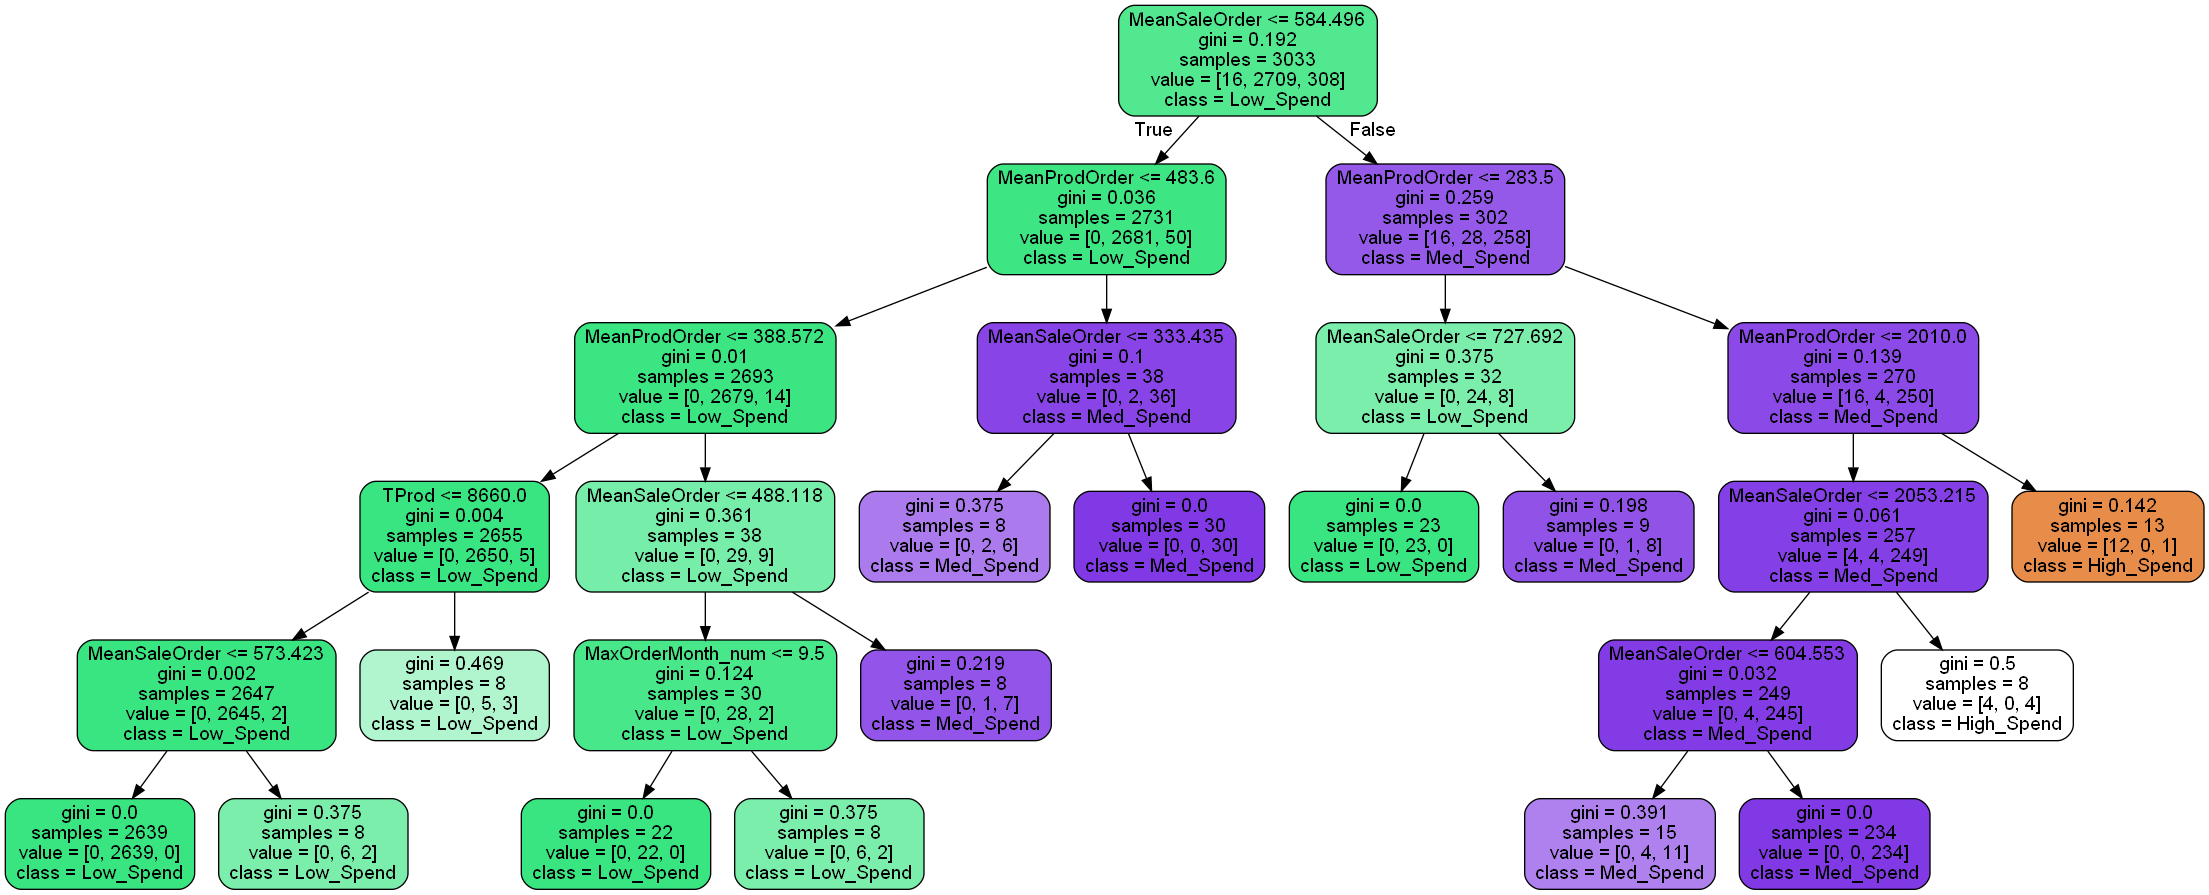

In [7]:
#visualize the actual decision tree obtained  
classes = ['High_Spend','Low_Spend','Med_Spend']
dot_data = tree.export_graphviz(dt, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=classes,  #in transforming to numerical this order is mapped to 0,1,2 because of lexicographical
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [8]:
#predict using the decision tree
#the predict function returns the actual predicted labels: we need them for the evaluation phase
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

In [9]:
#evaulate the accuracy on the train set and the test set
#metrics also contains precision, recall, f1 and the support
print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_dt))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_dt))
print('Precision train set ', metrics.precision_score(train_label, train_pred_dt, average='weighted'))
print('Recall train set ', metrics.recall_score(train_label, train_pred_dt, average='weighted'))
print('F1 score train set ', metrics.f1_score(train_label, train_pred_dt, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_dt))

Accuracy train set  0.9934058687767886
Accuracy test set  0.9815384615384616
Precision train set  0.9937628183643427
Recall train set  0.9934058687767886
F1 score train set  0.9934952501914048
Support train set  (array([0.76190476, 0.99741507, 0.97368421]), array([1.        , 0.99704688, 0.96103896]), array([0.86486486, 0.99723094, 0.96732026]), array([  16, 2709,  308], dtype=int64))


In [10]:
report_scores(test_label, test_pred_dt)

              precision    recall  f1-score   support

  High_Spend       0.80      0.80      0.80        10
   Low_Spend       0.99      1.00      0.99      1149
   Med_Spend       0.95      0.88      0.91       141

    accuracy                           0.98      1300
   macro avg       0.91      0.89      0.90      1300
weighted avg       0.98      0.98      0.98      1300



In [11]:
#compute confusion matrix
cm = confusion_matrix(test_label, test_pred_dt)
cm

array([[   8,    0,    2],
       [   0, 1144,    5],
       [   2,   15,  124]], dtype=int64)

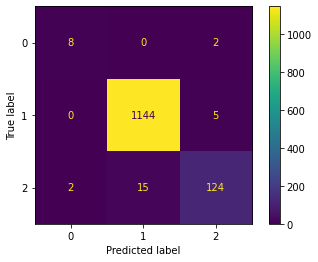

In [12]:
#it is possible to plot the confusion matrix 
plot_confusion_matrix(dt, test_set, test_label)
plt.show() 

### Random Forest

**Grid search for parameter setting**

In [13]:
#define the parameters' values you want to try
num_estimators = 30
param_dist = {"max_depth": [3,5,6,7,8,9,10,11,12,None],
              "max_features": sp_randint(1, 10),
              "min_samples_split": sp_randint(3, 20),
              "min_samples_leaf": sp_randint(5, 20),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"]}
#define the number of iters
n_iter_search = 50
#define the model
clf = RandomForestClassifier(n_estimators=num_estimators)
#define the grid search
grid_search = RandomizedSearchCV(clf, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=1, 
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search.fit(train_set, train_label)

RandomizedSearchCV(estimator=RandomForestClassifier(n_estimators=30), n_iter=50,
                   n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [3, 5, 6, 7, 8, 9, 10, 11,
                                                      12, None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001636D939D30>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001636B8CFA30>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001636B911940>},
                   scoring=make_scorer(accuracy_score))

In [14]:
print('Best setting parameters ', grid_search.cv_results_['params'][0])
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][0], 
      grid_search.cv_results_['std_test_score'][0])

Best setting parameters  {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 11, 'max_features': 4, 'min_samples_leaf': 6, 'min_samples_split': 14}
Mean and std of this setting  0.9871417619521425 0.0012299672069469296


In [15]:
grid_search.cv_results_['params'][0]

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 11,
 'max_features': 4,
 'min_samples_leaf': 6,
 'min_samples_split': 14}

In [16]:
rf = RandomForestClassifier(n_estimators=30, 
                             criterion=grid_search.cv_results_['params'][0]['criterion'],
                             max_features=grid_search.cv_results_['params'][0]['max_features'],
                             max_depth=grid_search.cv_results_['params'][0]['max_depth'], 
                             min_samples_split=grid_search.cv_results_['params'][0]['min_samples_split'],
                             min_samples_leaf=grid_search.cv_results_['params'][0]['min_samples_leaf'],
                             bootstrap=grid_search.cv_results_['params'][0]['bootstrap']) 
rf = rf.fit(train_set, train_label)

In [17]:
#prediction on the test test
test_pred_rf = rf.predict(test_set)

In [18]:
#compute the performance of the model
report_scores(test_label, test_pred_rf)

              precision    recall  f1-score   support

  High_Spend       1.00      0.40      0.57        10
   Low_Spend       0.99      1.00      0.99      1149
   Med_Spend       0.94      0.94      0.94       141

    accuracy                           0.99      1300
   macro avg       0.98      0.78      0.84      1300
weighted avg       0.99      0.99      0.99      1300



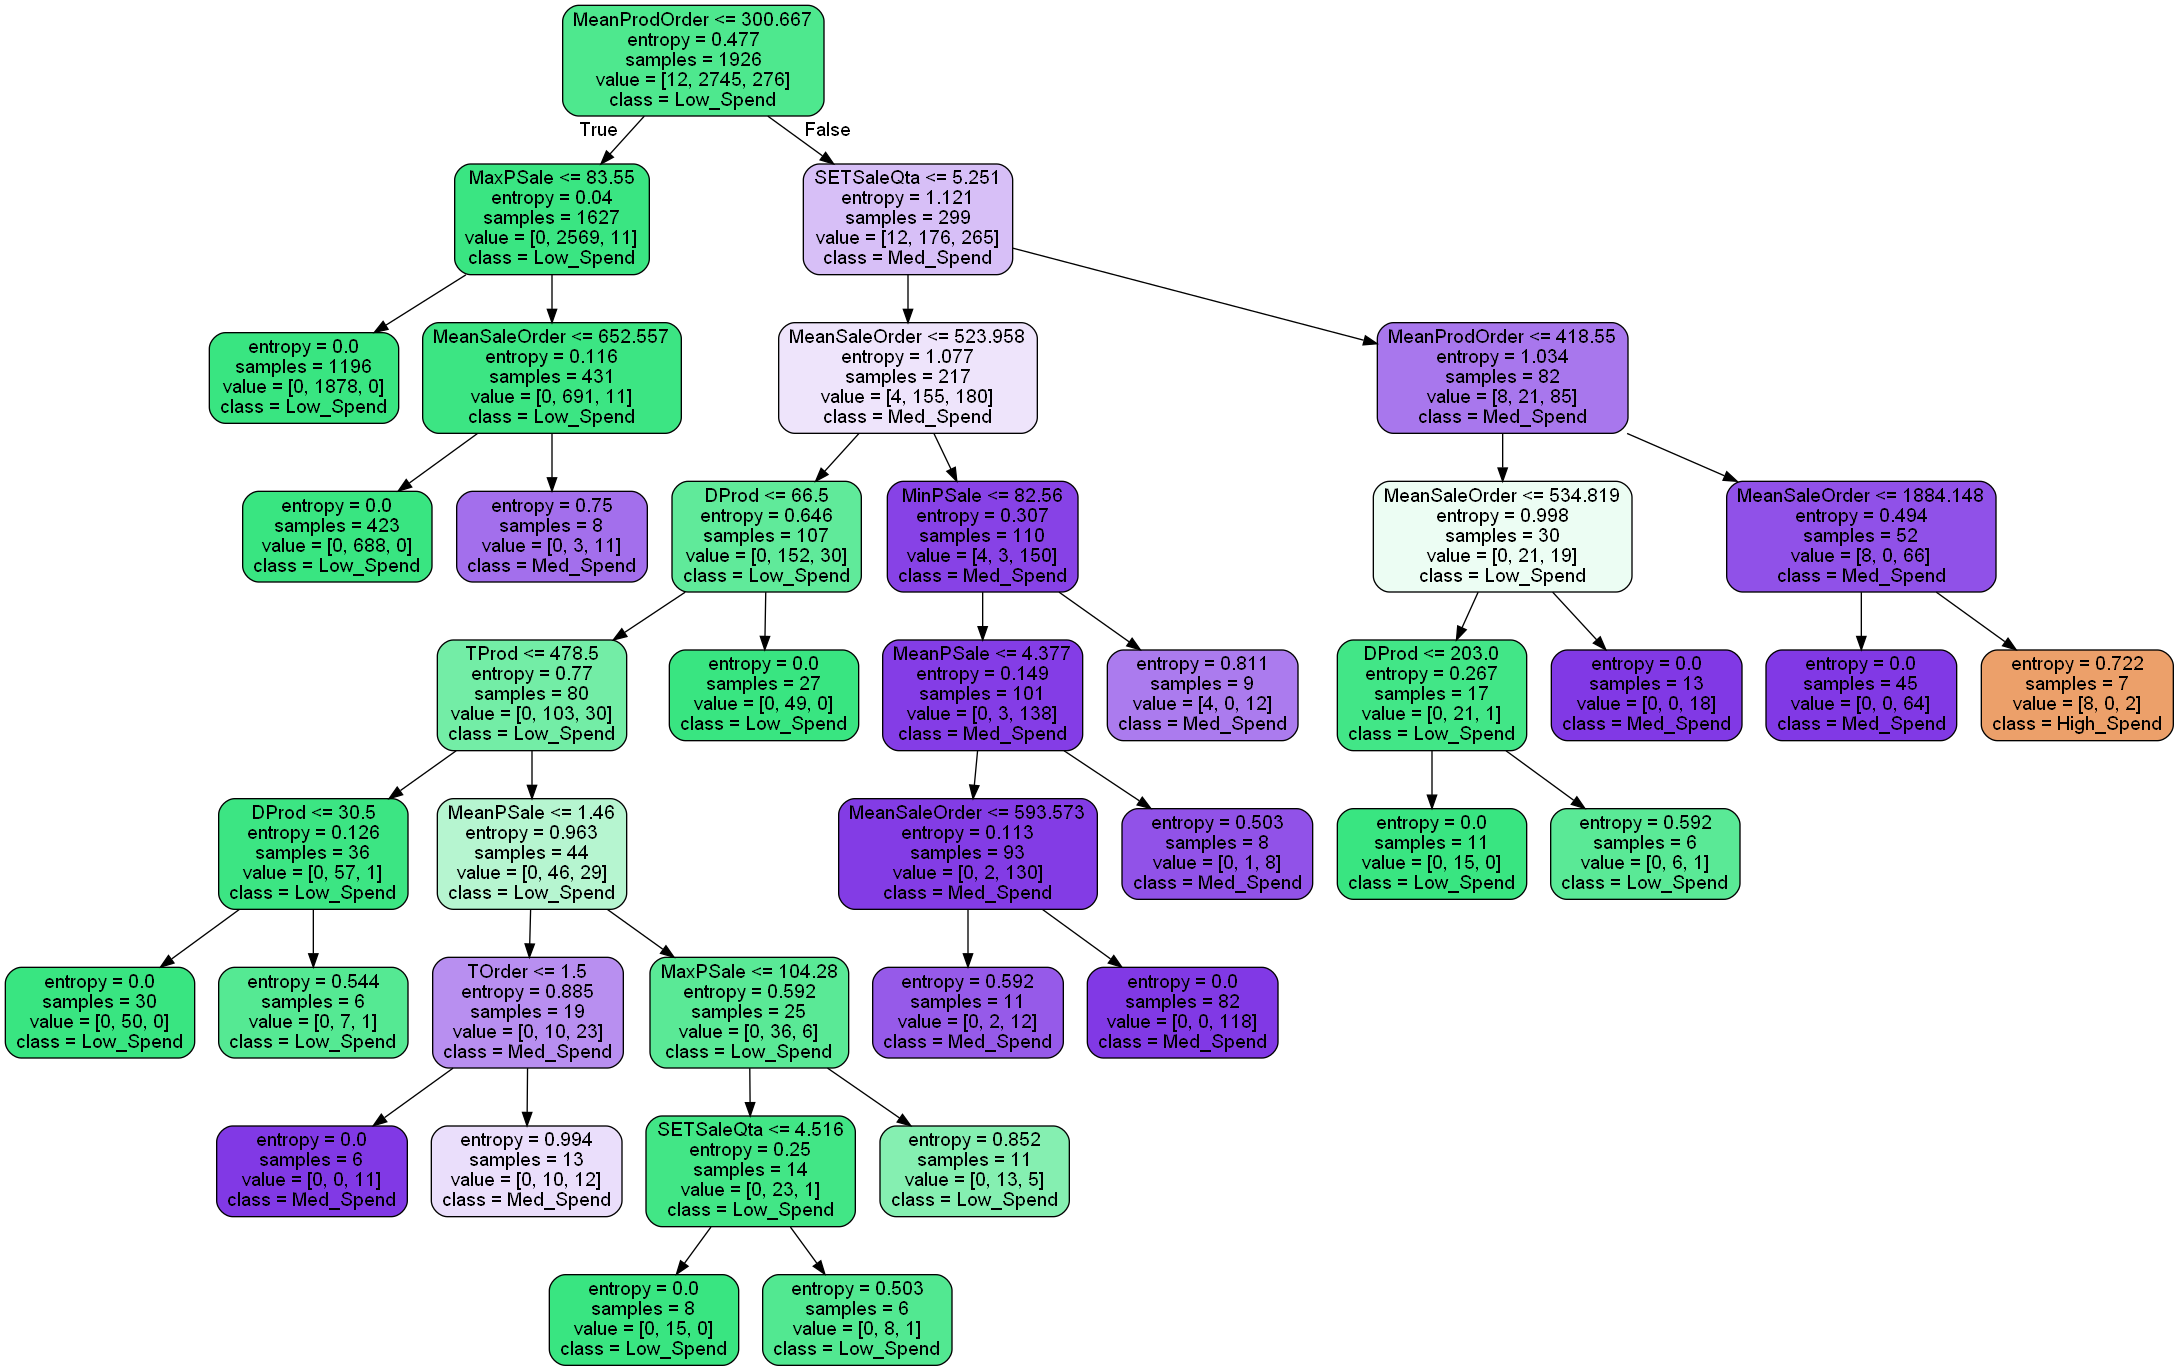

In [19]:
# forest is composed of lots of dt, visualize one just for fun
dot_data = tree.export_graphviz(rf[0], out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=classes,
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

### Naive Bayes

In [20]:
#define and fit the model
gnb = GaussianNB()
gnb.fit(train_set, train_label)

#predict on the test set
test_pred_gnb = gnb.predict(test_set)

In [21]:
#compute the performance of the model
report_scores(test_label,test_pred_gnb)

              precision    recall  f1-score   support

  High_Spend       0.53      0.90      0.67        10
   Low_Spend       0.96      0.96      0.96      1149
   Med_Spend       0.67      0.65      0.66       141

    accuracy                           0.93      1300
   macro avg       0.72      0.84      0.76      1300
weighted avg       0.93      0.93      0.93      1300



### KNN

In [22]:
knn = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree', metric='minkowski').fit(train_set, train_label)

#prediction on the test test
test_pred_knn = knn.predict(test_set)

In [23]:
#compute the performance of the model
report_scores(test_label,test_pred_knn)

              precision    recall  f1-score   support

  High_Spend       1.00      0.40      0.57        10
   Low_Spend       0.97      0.99      0.98      1149
   Med_Spend       0.90      0.74      0.81       141

    accuracy                           0.96      1300
   macro avg       0.96      0.71      0.79      1300
weighted avg       0.96      0.96      0.96      1300



### SVM

In [24]:
svm = SVC(kernel='sigmoid', C=0.6, gamma='scale', probability=True)
svm.fit(train_set, train_label)

SVC(C=0.6, kernel='sigmoid', probability=True)

In [25]:
#prediction on the test test
test_pred_proba_svm = svm.predict_proba(test_set)

In [26]:
test_pred_svm = svm.predict(test_set)

In [27]:
#compute the performance of the model (only oversample because without it no element is classified as High_Spend)
print(classification_report(test_label, 
                            test_pred_svm, 
                            target_names=classes))

              precision    recall  f1-score   support

  High_Spend       0.00      0.00      0.00        10
   Low_Spend       0.90      1.00      0.95      1149
   Med_Spend       0.83      0.13      0.23       141

    accuracy                           0.90      1300
   macro avg       0.58      0.38      0.39      1300
weighted avg       0.88      0.90      0.86      1300



C:\Users\beppe\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


***

## CLASSIFICATION on OVERSAMPLED TRAIN SET (SMOTE)

SMOTE is a different stratification method which applies oversampling to the classes. The difference between this method and the basic oversampling applied before stands in the generation of new data:
* in the basic oversampling, original data is simply copied to create exact (but additional) new data
* in SMOTE oversampling, original data is used to create new data which copies the old one adding a [0,1] perturbation, hence generating truly new data

In [28]:
strat = {1: Counter(train_label)[1], 2: Counter(train_label)[2], 0: Counter(train_label)[2] }
smote = SMOTE(
    sampling_strategy=strat,    # resample all classes but the majority one
    k_neighbors=5
)

train_set_smote, train_label_smote = smote.fit_resample(train_set, train_label)

In [29]:
Counter(train_label_smote)

Counter({1: 2709, 2: 308, 0: 308})

### Random Forest

Try grid search again, on this more balanced dataset

In [30]:
clf_smote = RandomForestClassifier(n_estimators=num_estimators)
#define the grid search
grid_search_smote = RandomizedSearchCV(clf_smote, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=1, 
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_smote.fit(train_set_smote, train_label_smote)

RandomizedSearchCV(estimator=RandomForestClassifier(n_estimators=30), n_iter=50,
                   n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [3, 5, 6, 7, 8, 9, 10, 11,
                                                      12, None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001636D939D30>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001636B8CFA30>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001636B911940>},
                   scoring=make_scorer(accuracy_score))

In [31]:
print('Best setting parameters ', grid_search_smote.cv_results_['params'][0])
print('Mean and std of this setting ', grid_search_smote.cv_results_['mean_test_score'][0], 
      grid_search_smote.cv_results_['std_test_score'][0])

Best setting parameters  {'bootstrap': True, 'criterion': 'gini', 'max_depth': 8, 'max_features': 2, 'min_samples_leaf': 5, 'min_samples_split': 7}
Mean and std of this setting  0.9876691729323308 0.003481454707606097


In [32]:
rf_smote = RandomForestClassifier(n_estimators=num_estimators, 
                             criterion=grid_search_smote.cv_results_['params'][0]['criterion'],
                             max_features=grid_search_smote.cv_results_['params'][0]['max_features'],
                             max_depth=grid_search_smote.cv_results_['params'][0]['max_depth'], 
                             min_samples_split=grid_search_smote.cv_results_['params'][0]['min_samples_split'],
                             min_samples_leaf=grid_search_smote.cv_results_['params'][0]['min_samples_leaf'],
                             bootstrap=grid_search_smote.cv_results_['params'][0]['bootstrap'])
rf_smote = rf_smote.fit(train_set_smote, train_label_smote)

In [33]:
#prediction on the test test
test_pred_rf = rf_smote.predict(test_set)

In [34]:
#compute the performance of the model
report_scores(test_label, test_pred_rf)

              precision    recall  f1-score   support

  High_Spend       0.80      0.80      0.80        10
   Low_Spend       0.99      1.00      0.99      1149
   Med_Spend       0.97      0.87      0.92       141

    accuracy                           0.98      1300
   macro avg       0.92      0.89      0.90      1300
weighted avg       0.98      0.98      0.98      1300



### Naive Bayes

In [35]:
gnb = GaussianNB()
gnb.fit(train_set_smote, train_label_smote)

#predict on the test set
test_pred_gnb = gnb.predict(test_set)

In [36]:
#compute the performance of the model
report_scores(test_label,test_pred_gnb)

              precision    recall  f1-score   support

  High_Spend       0.53      0.90      0.67        10
   Low_Spend       0.96      0.96      0.96      1149
   Med_Spend       0.67      0.64      0.65       141

    accuracy                           0.93      1300
   macro avg       0.72      0.83      0.76      1300
weighted avg       0.93      0.93      0.93      1300



### KNN

In [37]:
knn = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree', metric='minkowski').fit(train_set_smote, train_label_smote)

#prediction on the test test
test_pred_knn = knn.predict(test_set)

In [38]:
#compute the performance of the model
report_scores(test_label,test_pred_knn)

              precision    recall  f1-score   support

  High_Spend       0.59      1.00      0.74        10
   Low_Spend       0.97      0.99      0.98      1149
   Med_Spend       0.95      0.70      0.81       141

    accuracy                           0.96      1300
   macro avg       0.84      0.90      0.84      1300
weighted avg       0.96      0.96      0.96      1300



### SVM

In [39]:
svm = SVC(kernel='sigmoid', C=0.6, gamma='scale', probability=True)
svm.fit(train_set_smote, train_label_smote)

SVC(C=0.6, kernel='sigmoid', probability=True)

In [40]:
#prediction on the test test
test_pred_proba_svm = svm.predict_proba(test_set)

In [41]:
test_pred_svm = svm.predict(test_set)

In [42]:
#compute the performance of the model (only oversample because without it no element is classified as High_Spend)
print(classification_report(test_label, 
                            test_pred_svm, 
                            target_names=classes))

              precision    recall  f1-score   support

  High_Spend       0.05      0.40      0.08        10
   Low_Spend       0.91      0.95      0.93      1149
   Med_Spend       0.00      0.00      0.00       141

    accuracy                           0.85      1300
   macro avg       0.32      0.45      0.34      1300
weighted avg       0.80      0.85      0.82      1300



***

## CLASSIFICATION on OVERSAMPLED TRAIN SET and TEST SET (SMOTE)

In [43]:
# before starting classification we apply stratification to test set to have more data in less populated class
# we do this because otherwise our test set would be populated of < 10 elements for High_Spend class, giving a susceptible evaluation  
strat = {1: Counter(test_label)[1], 2: Counter(test_label)[2], 0: Counter(test_label)[2] }
smote = SMOTE(
    sampling_strategy=strat,    # resample all classes but the majority one
    k_neighbors=5
)
test_set, test_label = smote.fit_resample(test_set, test_label)
Counter(test_label)

Counter({1: 1149, 2: 141, 0: 141})

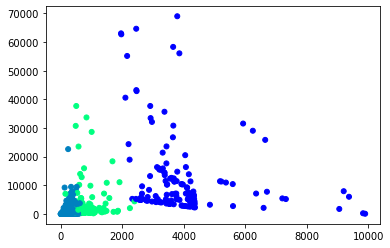

In [44]:
from sklearn.datasets import make_blobs
plt.scatter(test_set.iloc[:, 6].values, test_set.iloc[:, 0].values, c=test_label.values, s=25, cmap='winter');

In [45]:
Counter(train_label_smote)

Counter({1: 2709, 2: 308, 0: 308})

### Random Forest

Try grid search again, on this more balanced dataset

In [46]:
clf_smote = RandomForestClassifier(n_estimators=num_estimators)
#define the grid search
grid_search_smote = RandomizedSearchCV(clf_smote, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=1, 
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_smote.fit(train_set_smote, train_label_smote)

RandomizedSearchCV(estimator=RandomForestClassifier(n_estimators=30), n_iter=50,
                   n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [3, 5, 6, 7, 8, 9, 10, 11,
                                                      12, None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001636D939D30>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001636B8CFA30>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001636B911940>},
                   scoring=make_scorer(accuracy_score))

In [47]:
print('Best setting parameters ', grid_search_smote.cv_results_['params'][0])
print('Mean and std of this setting ', grid_search_smote.cv_results_['mean_test_score'][0], 
      grid_search_smote.cv_results_['std_test_score'][0])

Best setting parameters  {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 9, 'max_features': 8, 'min_samples_leaf': 16, 'min_samples_split': 19}
Mean and std of this setting  0.9849624060150377 0.004145578572057178


In [48]:
rf_smote = RandomForestClassifier(n_estimators=num_estimators, 
                             criterion=grid_search_smote.cv_results_['params'][0]['criterion'],
                             max_features=grid_search_smote.cv_results_['params'][0]['max_features'],
                             max_depth=grid_search_smote.cv_results_['params'][0]['max_depth'], 
                             min_samples_split=grid_search_smote.cv_results_['params'][0]['min_samples_split'],
                             min_samples_leaf=grid_search_smote.cv_results_['params'][0]['min_samples_leaf'],
                             bootstrap=grid_search_smote.cv_results_['params'][0]['bootstrap'])
rf_smote = rf_smote.fit(train_set_smote, train_label_smote)

In [49]:
#prediction on the test test
test_pred_rf = rf_smote.predict(test_set)

In [50]:
#compute the performance of the model
report_scores(test_label, test_pred_rf)

              precision    recall  f1-score   support

  High_Spend       1.00      0.76      0.86       141
   Low_Spend       0.99      0.99      0.99      1149
   Med_Spend       0.76      0.91      0.83       141

    accuracy                           0.96      1431
   macro avg       0.92      0.89      0.89      1431
weighted avg       0.97      0.96      0.96      1431



### Naive Bayes

In [51]:
gnb = GaussianNB()
gnb.fit(train_set_smote, train_label_smote)

#predict on the test set
test_pred_gnb = gnb.predict(test_set)

In [52]:
#compute the performance of the model
report_scores(test_label,test_pred_gnb)

              precision    recall  f1-score   support

  High_Spend       0.94      0.84      0.88       141
   Low_Spend       0.96      0.96      0.96      1149
   Med_Spend       0.57      0.64      0.60       141

    accuracy                           0.92      1431
   macro avg       0.82      0.81      0.82      1431
weighted avg       0.92      0.92      0.92      1431



### KNN

In [53]:
knn = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree', metric='minkowski').fit(train_set_smote, train_label_smote)

#prediction on the test test
test_pred_knn = knn.predict(test_set)

In [54]:
#compute the performance of the model
report_scores(test_label,test_pred_knn)

              precision    recall  f1-score   support

  High_Spend       0.95      0.94      0.94       141
   Low_Spend       0.97      0.99      0.98      1149
   Med_Spend       0.88      0.70      0.78       141

    accuracy                           0.96      1431
   macro avg       0.93      0.88      0.90      1431
weighted avg       0.96      0.96      0.96      1431



### SVM

In [55]:
svm = SVC(kernel='sigmoid', C=0.6, gamma='scale', probability=True)
svm.fit(train_set_smote, train_label_smote)

SVC(C=0.6, kernel='sigmoid', probability=True)

In [56]:
#prediction on the test test
test_pred_proba_svm = svm.predict_proba(test_set)

In [57]:
test_pred_svm = svm.predict(test_set)

In [58]:
#compute the performance of the model (only oversample because without it no element is classified as High_Spend)
print(classification_report(test_label, 
                            test_pred_svm, 
                            target_names=classes))

              precision    recall  f1-score   support

  High_Spend       0.47      0.54      0.50       141
   Low_Spend       0.87      0.95      0.91      1149
   Med_Spend       0.00      0.00      0.00       141

    accuracy                           0.82      1431
   macro avg       0.45      0.50      0.47      1431
weighted avg       0.74      0.82      0.78      1431



***

# WORKING ON FUZZY DATA

In [59]:
# Starting dataset
df_f = pd.read_csv('datasets/clustered_fuzzy_dataframe.csv', sep='\t', index_col=0)
df_f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4333 entries, 17850 to 12713
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TProd           4333 non-null   int64  
 1   DProd           4333 non-null   int64  
 2   MeanProdOrder   4333 non-null   float64
 3   TSale           4333 non-null   float64
 4   MinPSale        4333 non-null   float64
 5   MaxPSale        4333 non-null   float64
 6   MeanSaleOrder   4333 non-null   float64
 7   TRProd          4333 non-null   int64  
 8   MeanPSale       4333 non-null   float64
 9   TOrder          4333 non-null   int64  
 10  SETSaleQta      4333 non-null   float64
 11  SESaleQtaOrder  4333 non-null   float64
 12  MaxOrderMonth   4333 non-null   object 
 13  Label           4333 non-null   object 
dtypes: float64(8), int64(4), object(2)
memory usage: 507.8+ KB


In [60]:
# we only have 2 categorical attributes, discretize them and get rid of them
df_f = discretize_data(df_f,['MaxOrderMonth','Label'])
df_f.drop(columns=['MaxOrderMonth','Label'], inplace=True, errors='ignore')
df_f_class = df_f.copy()
df_f_class.tail()

,TProd,DProd,MeanProdOrder,TSale,MinPSale,MaxPSale,MeanSaleOrder,TRProd,MeanPSale,TOrder,SETSaleQta,SESaleQtaOrder,MaxOrderMonth_num,Label_num
CustomerID,,,,,,,,,,,,,,
13436,76,12,76.0,196.89,10.20,25.50,196.89,0,5.830,1,3.418,0.0,1,1
15520,314,18,314.0,343.50,9.48,34.68,343.50,0,1.724,1,2.997,0.0,1,2
13298,96,2,96.0,360.00,90.00,270.00,360.00,0,3.750,1,1.000,0.0,1,1
14569,79,10,79.0,227.39,1.65,122.40,227.39,0,3.920,1,3.418,0.0,1,1
12713,505,37,505.0,794.55,5.04,71.70,794.55,0,2.085,1,4.101,0.0,11,2


In [61]:
#to classify, we first need to split the dataset into train and test dataset.
#we can do so using train_test_split, in this case we select a stratified split
label = df_f_class.pop('Label_num')
train_set_f, test_set_f, train_label_f, test_label_f = train_test_split(df_f_class, label, test_size=0.30)

***

### Decision Tree (only to illustrate possible method results)

In [62]:
#define a decision tree and fit it
dt_f = tree.DecisionTreeClassifier(criterion='gini', splitter='best', 
                                  max_depth=6, 
                                  min_samples_split=3, min_samples_leaf=8)
dt_f = dt_f.fit(train_set_f, train_label_f)

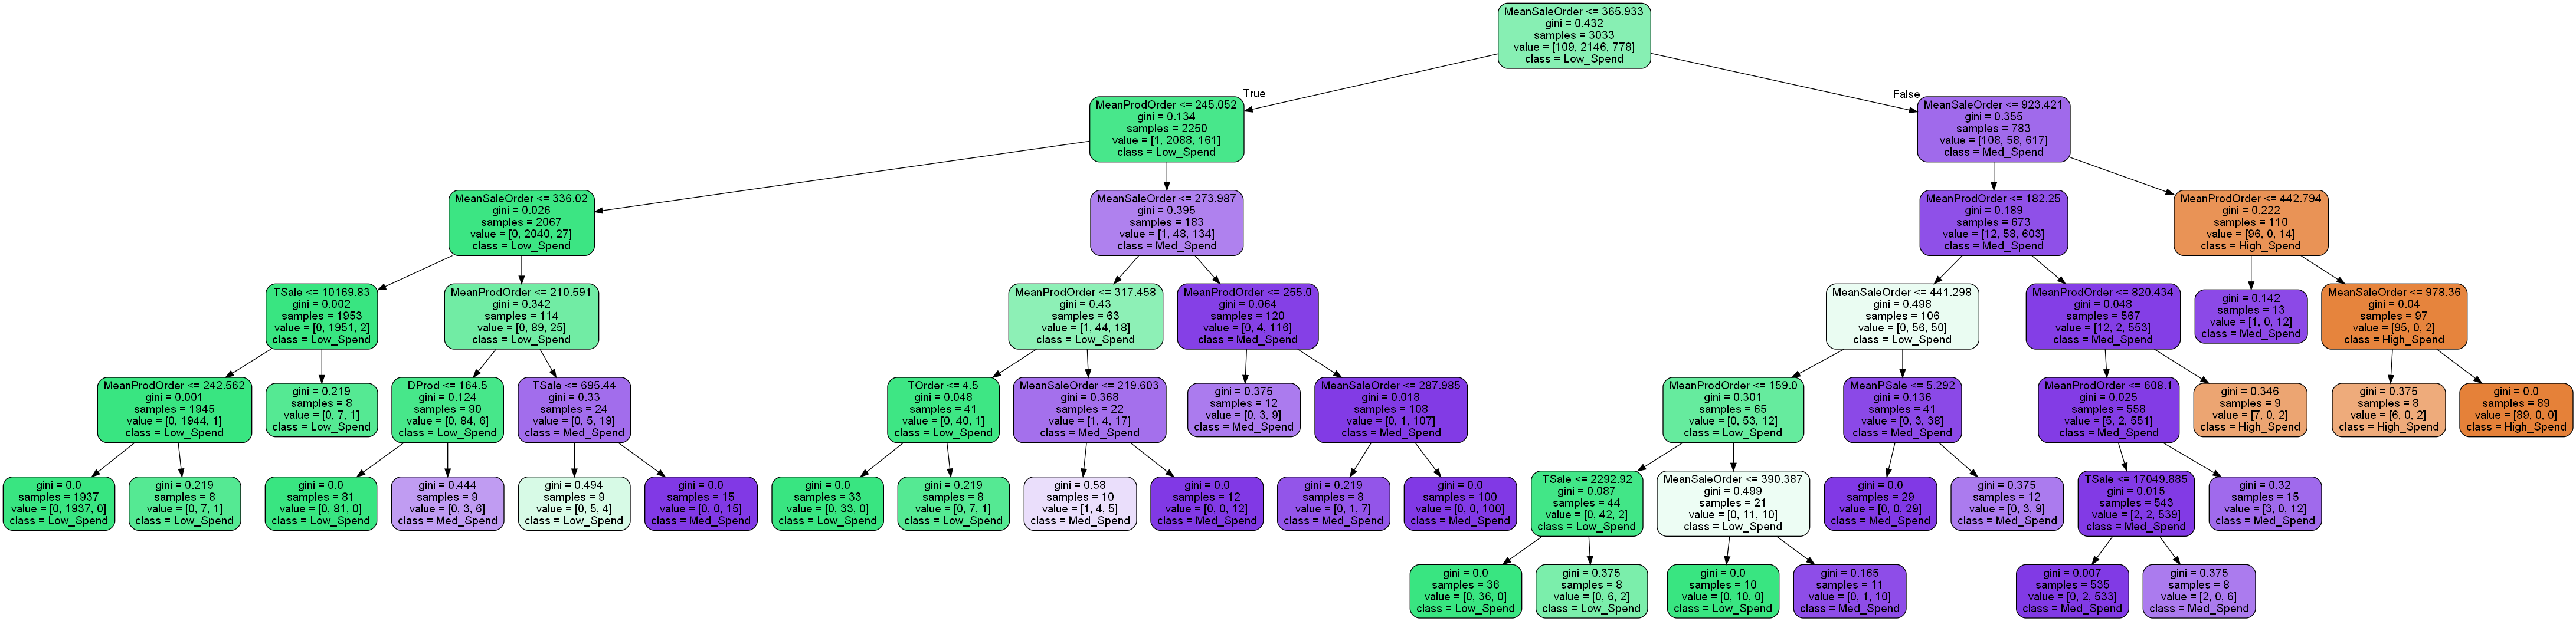

In [63]:
#visualize the actual decision tree obtained  
dot_data_f = tree.export_graphviz(dt_f, out_file=None, 
                         feature_names=list(train_set_f.columns),  
                         class_names=classes,  #in transforming to numerical this order is mapped to 0,1,2 because of lexicographical
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data_f)  
Image(graph.create_png())

In [64]:
#predict using the decision tree
#the predict function returns the actual predicted labels: we need them for the evaluation phase
train_pred_dt_f = dt_f.predict(train_set_f)
test_pred_dt_f = dt_f.predict(test_set_f)

In [65]:
report_scores(test_label_f, test_pred_dt_f)

              precision    recall  f1-score   support

  High_Spend       1.00      0.87      0.93        53
   Low_Spend       0.98      0.98      0.98       932
   Med_Spend       0.93      0.96      0.94       315

    accuracy                           0.97      1300
   macro avg       0.97      0.94      0.95      1300
weighted avg       0.97      0.97      0.97      1300



### Random Forest

**Grid search for parameter setting**

In [86]:
clf_f = RandomForestClassifier(n_estimators=30)
#define the grid search
grid_search_f = RandomizedSearchCV(clf_f, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=1, 
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_f.fit(train_set_f, train_label_f)

RandomizedSearchCV(estimator=RandomForestClassifier(n_estimators=30), n_iter=50,
                   n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [3, 5, 6, 7, 8, 9, 10, 11,
                                                      12, None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001636D939D30>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001636B8CFA30>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001636B911940>},
                   scoring=make_scorer(accuracy_score))

In [87]:
print('Best setting parameters ', grid_search_f.cv_results_['params'][0])
print('Mean and std of this setting ', grid_search_f.cv_results_['mean_test_score'][0], 
      grid_search_f.cv_results_['std_test_score'][0])

Best setting parameters  {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 4, 'min_samples_leaf': 6, 'min_samples_split': 18}
Mean and std of this setting  0.9554923037608539 0.007206654524205281


In [88]:
grid_search_f.cv_results_['params'][0]

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 3,
 'max_features': 4,
 'min_samples_leaf': 6,
 'min_samples_split': 18}

In [89]:
rf_f = RandomForestClassifier(n_estimators=num_estimators, 
                             criterion=grid_search_f.cv_results_['params'][0]['criterion'],
                             max_features=grid_search_f.cv_results_['params'][0]['max_features'],
                             max_depth=grid_search_f.cv_results_['params'][0]['max_depth'], 
                             min_samples_split=grid_search_f.cv_results_['params'][0]['min_samples_split'],
                             min_samples_leaf=grid_search_f.cv_results_['params'][0]['min_samples_leaf'],
                             bootstrap=grid_search_f.cv_results_['params'][0]['bootstrap']) 
rf_f = rf_f.fit(train_set, train_label)

In [90]:
#prediction on the test test
test_pred_rf_f = rf_f.predict(test_set_f)

In [91]:
#compute the performance of the model
report_scores(test_label_f, test_pred_rf_f)

              precision    recall  f1-score   support

  High_Spend       0.00      0.00      0.00        53
   Low_Spend       0.80      1.00      0.89       932
   Med_Spend       0.60      0.24      0.35       315

    accuracy                           0.78      1300
   macro avg       0.47      0.41      0.41      1300
weighted avg       0.72      0.78      0.72      1300



C:\Users\beppe\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


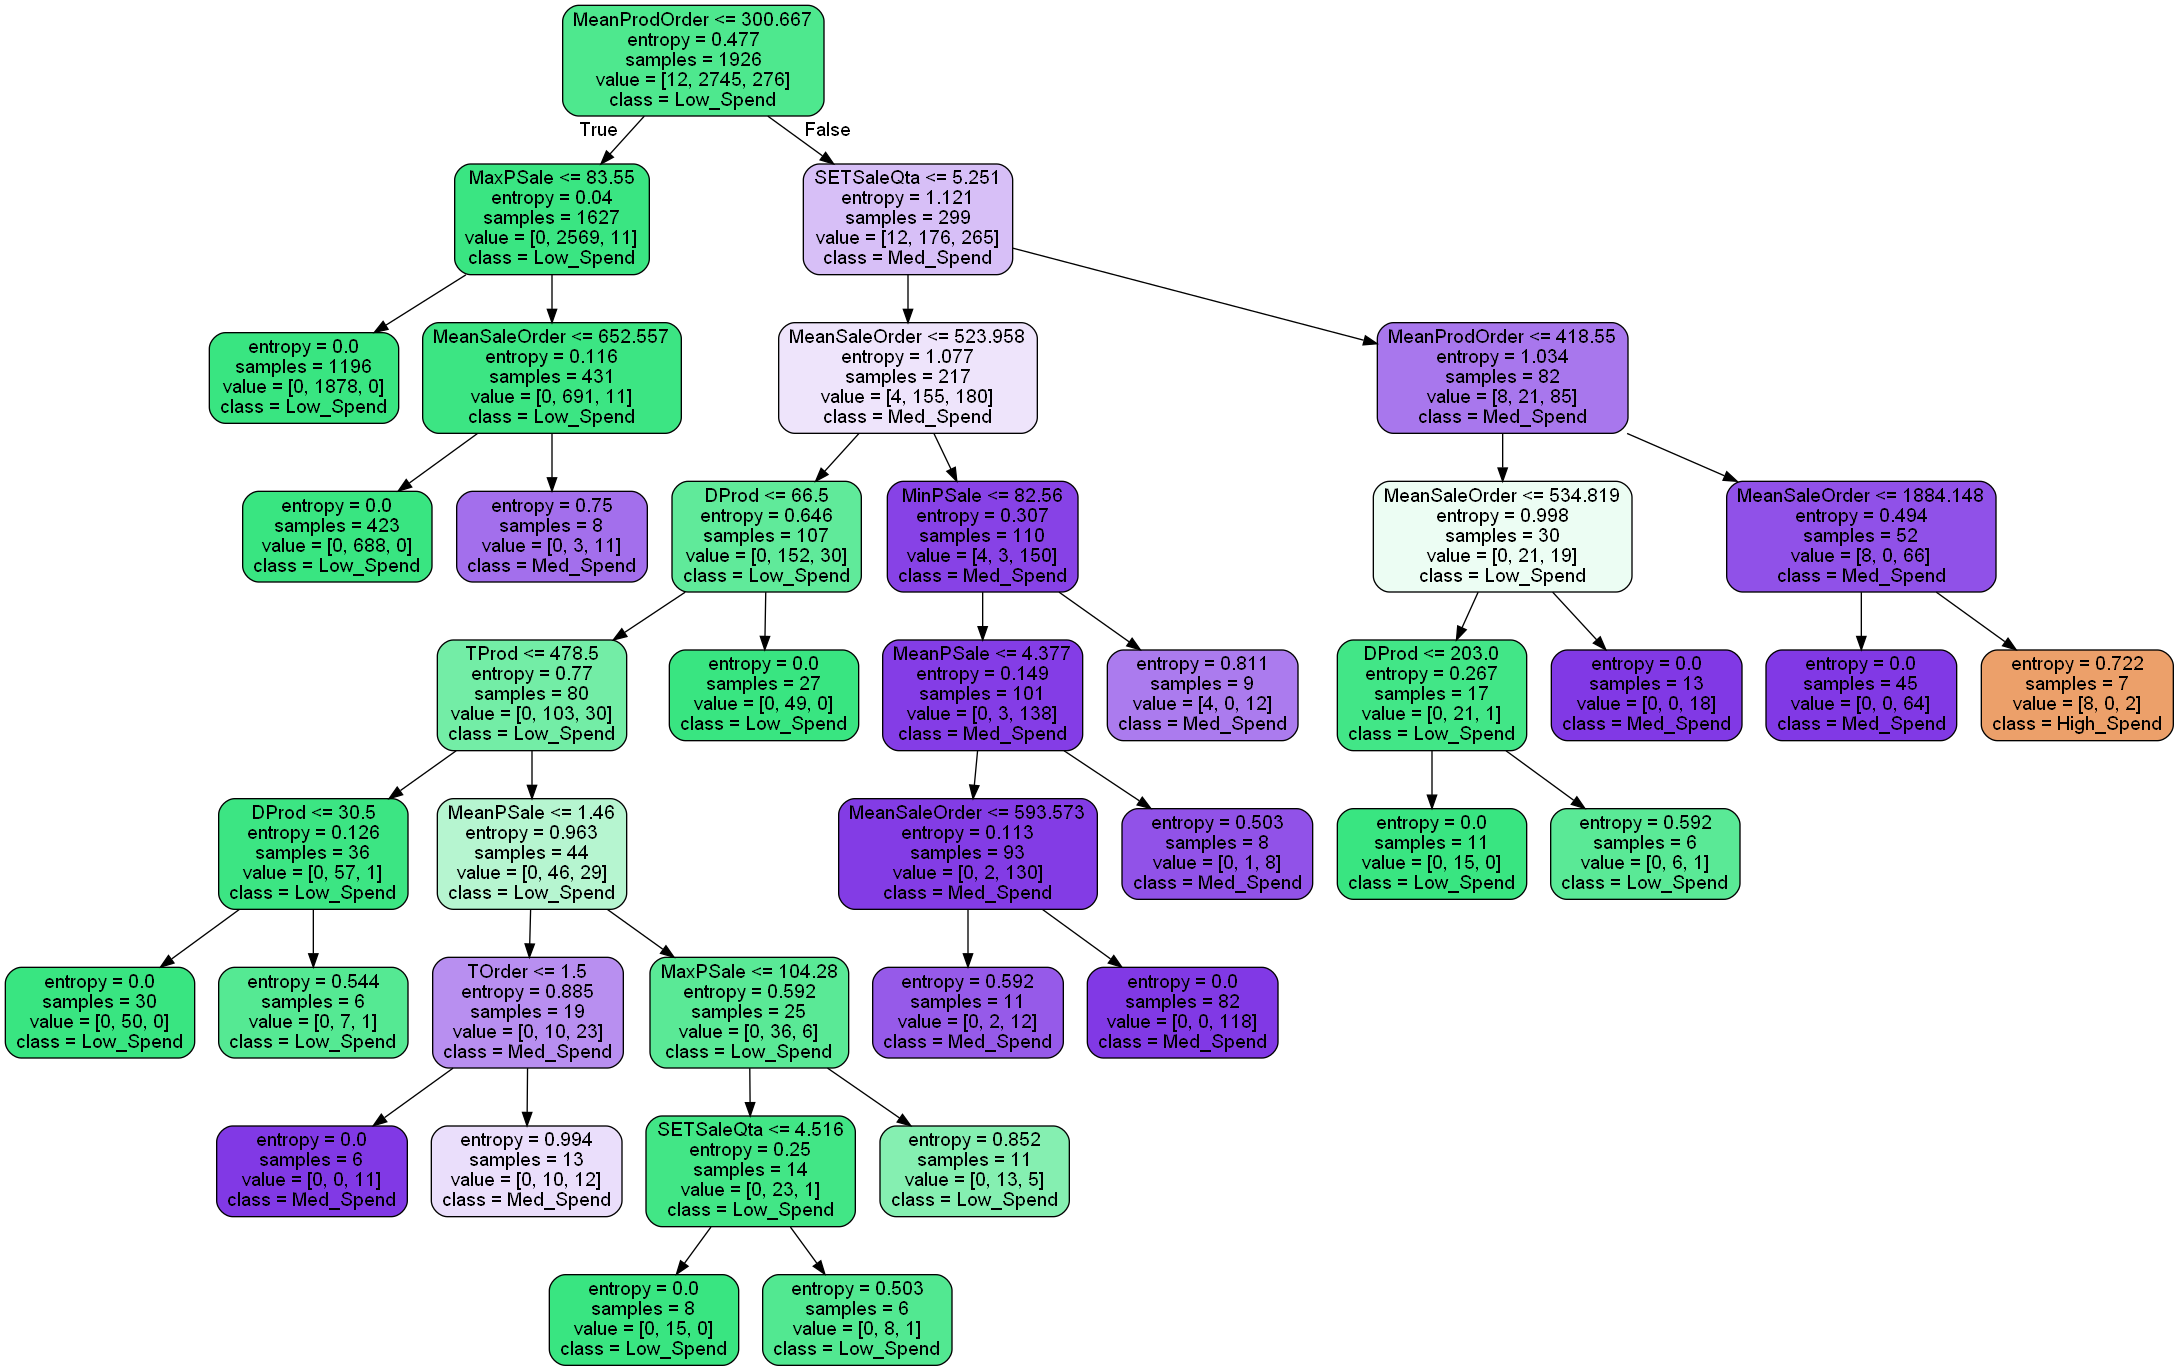

In [72]:
# forest is composed of lots of dt, visualize one just for fun
dot_data_f = tree.export_graphviz(rf[0], out_file=None, 
                         feature_names=list(train_set_f.columns),  
                         class_names=classes,
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data_f)  
Image(graph.create_png())

### Naive Bayes

In [73]:
#define and fit the model
gnb = GaussianNB()
gnb.fit(train_set_f, train_label_f)

#predict on the test set
test_pred_gnb = gnb.predict(test_set_f)

In [74]:
#compute the performance of the model
report_scores(test_label_f,test_pred_gnb)

              precision    recall  f1-score   support

  High_Spend       0.61      0.74      0.67        53
   Low_Spend       0.91      0.95      0.93       932
   Med_Spend       0.79      0.67      0.72       315

    accuracy                           0.87      1300
   macro avg       0.77      0.78      0.77      1300
weighted avg       0.87      0.87      0.87      1300



### KNN

In [75]:
knn = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree', metric='minkowski').fit(train_set_f, train_label_f)

#prediction on the test test
test_pred_knn = knn.predict(test_set_f)

In [76]:
#compute the performance of the model
report_scores(test_label_f,test_pred_knn)

              precision    recall  f1-score   support

  High_Spend       0.92      0.64      0.76        53
   Low_Spend       0.96      0.97      0.97       932
   Med_Spend       0.87      0.88      0.87       315

    accuracy                           0.94      1300
   macro avg       0.92      0.83      0.87      1300
weighted avg       0.94      0.94      0.94      1300



### SVM

In [77]:
svm = SVC(kernel='sigmoid', C=0.6, gamma='scale', probability=True)
svm.fit(train_set_f, train_label_f)

SVC(C=0.6, kernel='sigmoid', probability=True)

In [78]:
#prediction on the test test
test_pred_proba_svm = svm.predict_proba(test_set_f)

In [79]:
test_pred_svm_f = svm.predict(test_set_f)

In [80]:
#compute the performance of the model (only oversample because without it no element is classified as High_Spend)
print(classification_report(test_label_f, 
                            test_pred_svm_f, 
                            target_names=classes))

              precision    recall  f1-score   support

  High_Spend       0.44      0.40      0.42        53
   Low_Spend       0.79      0.97      0.87       932
   Med_Spend       0.49      0.18      0.26       315

    accuracy                           0.75      1300
   macro avg       0.57      0.51      0.52      1300
weighted avg       0.70      0.75      0.71      1300

